In [1]:
import os
import numpy as np
import scipy
import sys

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import glob
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.ndimage import interpolation as interp

#from skimage.feature.register_translation import (register_translation, _upsampled_dft)
#^ depracated, using the following instead
from skimage.registration import phase_cross_correlation
import aotools
import astroscrappy
from scipy.optimize import leastsq
import ccdproc
import gc
from utils import *

In [2]:
matplotlib.style.use('seaborn-ticks')
matplotlib.rc('lines',linewidth=2)
matplotlib.rc('axes',labelsize=30)
matplotlib.rc('figure',figsize=(12,8))
matplotlib.rc('xtick',labelsize=30)
matplotlib.rc('ytick',labelsize=30)

## Identify the data directory (where your data lives), and the output directory (where you want your final image to go), and let 'er rip! This next cell should automatically peruse your data directory for any fits files. It will then go through their headers and identify all the unique objects you've looked at, ignoring flats, darks, alignments, etc. At the end, you should have a list of all the targets that have data in that directory. Don't see your target? Make sure it's in the right directory!

In [21]:
datadir = 'Raw_Data/Test_Data/' #You change this!
outdir = 'Results/'


#################################


files = [os.path.basename(x) for x in glob.glob(datadir+'*')]           

#Want to make a target list for every target. This is the list that contains all target names, later
#We'll have a list for the data of every target
target_list = []

#Here we go through every file and check the objects name. If its a flat or a dark, we continue
#If it's a target, we check if it's in target_list. If it is, we continue. If it's not, we add it
for f in files:
    try:
        header = fits.getheader(datadir+f)
        obj = header['OBJECT']
        if (len(target_list) == 0 and 'dark' not in obj.lower() and 'flat' not in obj.lower()
            and 'alignment' not in obj.lower() and 'junk' not in obj.lower() and 'seeing' not in obj.lower()
            and 'optimization' not in obj.lower() and 'test' not in obj.lower()):
            target_list.append(obj)
        if obj in target_list:
            continue
        elif 'dark' in obj.lower():
            continue
        elif 'flat' in obj.lower():
            continue
        elif 'alignment' in obj.lower():
            continue
        elif 'junk' in obj.lower():
            continue
        elif 'seeing' in obj.lower():
            continue
        elif 'optimization' in obj.lower():
            continue
        elif 'test' in obj.lower():
            continue
        else:
            target_list.append(obj)
    except OSError:
        continue
    except KeyError:
        continue
            
#Optional part, but helpful. Sometimes the names of targets can mess up the later parts of this code, especially
#if they have strange characters. Here I replace two common ones with an acceptable replacement.
            
target_list_fixed = []

#The minus and + signs in some targets mess up the next part, so I replace them here
for i in range(len(target_list)):
    j = target_list[i].replace('-','_')
    k = j.replace('+','t')
    target_list_fixed.append(k)
    
target_list = target_list_fixed #just change it's name back for consistency
    
print('List of all the targets in your data directory:')
print(target_list)



List of all the targets in your data directory:
['172370679']


## Now You start off by picking a target from the list, and we will analyze that target. This next cell basically makes a list of all the files associated with that target. It also generates lists of flats and darks, and a few other odds and ends for use later

In [7]:
#We've identified our list of targets, now we pick our target and proceed
#I may go back and make this a loop at some point, but for now it is one at a time. 

#edit this line if you wanna change targets
target = target_list[0]



#these definitions ensure that all these lists are redifined for every target. Though the flat list and the
#dark list should stay the same between runs, the object list will change on each iteration. Essentially, each
#iteration is a new target, and so this list gets recycled every time
flat_list = [] #list of all the flats, duh
dark_list = [] # list of all the darks, dummy!
object_list = [] #this is a list that contains all the FILES that each target has, every exposure. Not
#to be confused with the actual target list, which only has one entry for every star we looked at
drkhdr_list =[] #this keeps the header for each dark. This is useful later for when we're sorting these by 
#exposure time
tot_exptime = 0 # this keeps track of how many seconds total we looked at this target



#Open the text file with the vetos in it
#there is another script that reads everything and auto vetos stuff for SNR reasons, or other poor quality indicators
veto_list = [line.rstrip('\n') for line in open(datadir+'veto_list.txt')]
#Now we organize this into flats and targets


print('Target: '+target)
#make a list of frames to veto
flat_veto_list = []
target_veto_list = []


for veto in veto_list:
    header = fits.getheader(datadir+veto)
    obj = header['OBJECT']
    objf = obj.replace('-','_')#having trouble with minus/plus signs again
    objk = objf.replace('+','t')
    if 'flat' in obj.lower():
            flat_veto_list.append(veto)
    elif objk == target:
        target_veto_list.append(veto)
    else:
        continue


##Let's add the ability to manually input vetos for this target; Let's manually put them in the veto list for now
mantarglist = (list(map(str, input(str(target)+': Enter Manual Veto Targets in fits file form, delineated by spaces i.e. s0300.fits').split())))
manflatlist = (list(map(str, input(str(target)+': Enter Manual Veto Flats in fits file form, delineated by spaces i.e. s0300.fits').split())))
        
        
for targ in mantarglist:
    target_veto_list.append(targ)
            
for flat in manflatlist:
    flat_veto_list.append(flat)

#This part basically takes objects and sorts them into either flats, darks, or targets
#Need to move flats/darks here, because I only want them by night
#The two if/else parts correspond to when the id is two digits or three
for f in files:
    try:
        header = fits.getheader(datadir+f)
        obj = header['OBJECT']
        objf = obj.replace('-','_')#having trouble with minus/plus signs again
        objk = objf.replace('+','t')
        if 'flat' in obj.lower():
            flat_list.append(f)
        elif 'test' in obj.lower():
            flat_list.append(f)
        elif 'dark' in obj.lower():
            dark_list.append(f)
            drkhdr_list.append(int(float(header['ITIME'])/1000))
        elif objk == target:
            object_list.append(f)
            tot_exptime = tot_exptime + float(header['ITIME'])/1000
    except OSError:
            continue
    except KeyError:
            continue

#I recommend using this point to ensure that all the right fits files are here for each target
#These have not removed the veto frames yet
if(len(object_list)==0):
    sys.exit('Nothing in the object list')
        



#Now we remove the bad/overexposed frames in the veto list           
for veto in target_veto_list:
    for ID in object_list:
        if ID == veto:
            object_list.remove(ID)
            continue


for veto in flat_veto_list:
    for ID in flat_list:
        if ID == veto:
            flat_list.remove(ID)
            continue


#We don't want targets with only a few images
if len(object_list)<5:
    sys.exit('Too few images')
            
print('Object List:')


#let's make a list that contains all our exposures

all_images_list = []

all_images_list = flat_list + object_list + dark_list

  
object_filter_list = []
        
#let's make a list of all the filters for a target, in case they change        
for i in range(len(object_list)):
    try:
        header = fits.getheader(datadir+object_list[i])
        filt = header['FILT1NAM']
        if len(object_filter_list) == 0:
            object_filter_list.append(filt)
        elif filt not in object_filter_list:
            object_filter_list.append(filt)
    except OSError:
        continue
                
       



    ############# Get the Image Data   ###################

raw_image_data = {}

        
for image_name in all_images_list:
    try:
        raw_image_data[image_name] = fits.getdata(datadir+image_name)
    except OSError:
        continue
                
                
                
#now we want to loop and do the rest of the code for each filter, but we need to make a new target list
#for all the targets in a particular filter
object_filter_list2 = [object_filter_list[0]]
        
for filter in object_filter_list2:
    newobjectlist = []
    for j in range(len(object_list)):              
        header = fits.getheader(datadir+object_list[j])
        filt = header['FILT1NAM']
        if filter == filt:
            newobjectlist.append(object_list[j])
        else:
            continue

object_list = newobjectlist
print(object_list)

Target: 172370679
172370679: Enter Manual Veto Targets in fits file form, delineated by spaces i.e. s0300.fits
172370679: Enter Manual Veto Flats in fits file form, delineated by spaces i.e. s0300.fits
Object List:
['s0210.fits', 's0207.fits', 's0216.fits', 's0221.fits', 's0218.fits', 's0222.fits', 's0219.fits', 's0204.fits', 's0208.fits']


In [10]:
#####################################################################################################

######################## Dark Correction ######################

#####################################################################################################

#Trying to make the dark correct routine more efficient
#let's create darkcubes for each different exposure time, rather than having it go through a for loop for every piece of data

            
#We also make a list without darks for dark-correcting later           
darkcor_list_in = newobjectlist+flat_list
        
darktime_list = [] #list of all the exposure times. There should be on for every exposure image we take
        
#this populates the darktime list
for i in range(len(dark_list)):
    try:                   
        if len(darktime_list) == 0:
            darktime_list.append(drkhdr_list[i])
        elif int(drkhdr_list[i]) not in darktime_list:
            darktime_list.append(drkhdr_list[i])
 
        else:
            continue
    except OSError:
        continue



#Now that we have a list of each dark exposure time, let's populate a dictionary with the frames for each time
darkname_dict = {}
masterdark_dict = {}
# for j in range(0,len(darktime_list)):
#     command = "" 
#     command = "dark_list_"+str(darktime_list[j])+" = [] " 
#     exec(command)

#Now I add the appropriate dark data to each list    
for dark in dark_list:
    try:
        darkheader = fits.getheader(datadir+dark)
        #print(dark)
        darktime = int(float(darkheader['ITIME'])/1000.)
        #print(darktime)
        darkname_dict[darktime].append(dark)
    except KeyError:
        darkname_dict[darktime] = [dark]
    except OSError:
        continue
        
for exptime in darktime_list:
    tempdict = {}
    for dark in darkname_dict[exptime]:
        tempdict[dark] = fits.getdata(datadir+dark)
    darkcube = np.stack([tempdict[dark] for dark in darkname_dict[exptime]],axis=0)
    masterdark_dict[exptime] = np.average(darkcube, axis=0)
        




## filenames for the corresponding dark-subtracted images:
darkcor_list_out = ['darkcor_' + im for im in darkcor_list_in]

## subtract the master dark from each of the raw science & flat frames: 

darkcor_data_out = {} ## dictionary for the dark-corrected images
        
removelist = []

        
for i in range(len(darkcor_list_in)):  
    try:
        darkcor_data_out[darkcor_list_out[i]] = dark_correct(darkcor_list_in[i], raw_image_data, masterdark_dict, datadir)
    except OSError:
        continue
                
    
for bad in removelist:
    darkcor_list_in.remove(bad)
    object_list.remove(bad)
    darkcor_list_out.remove('darkcor_'+ bad)


70
70
70
70
70
70
70
70
70
35
15
35
15
15
15
15
15
35
35
35
25


/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide


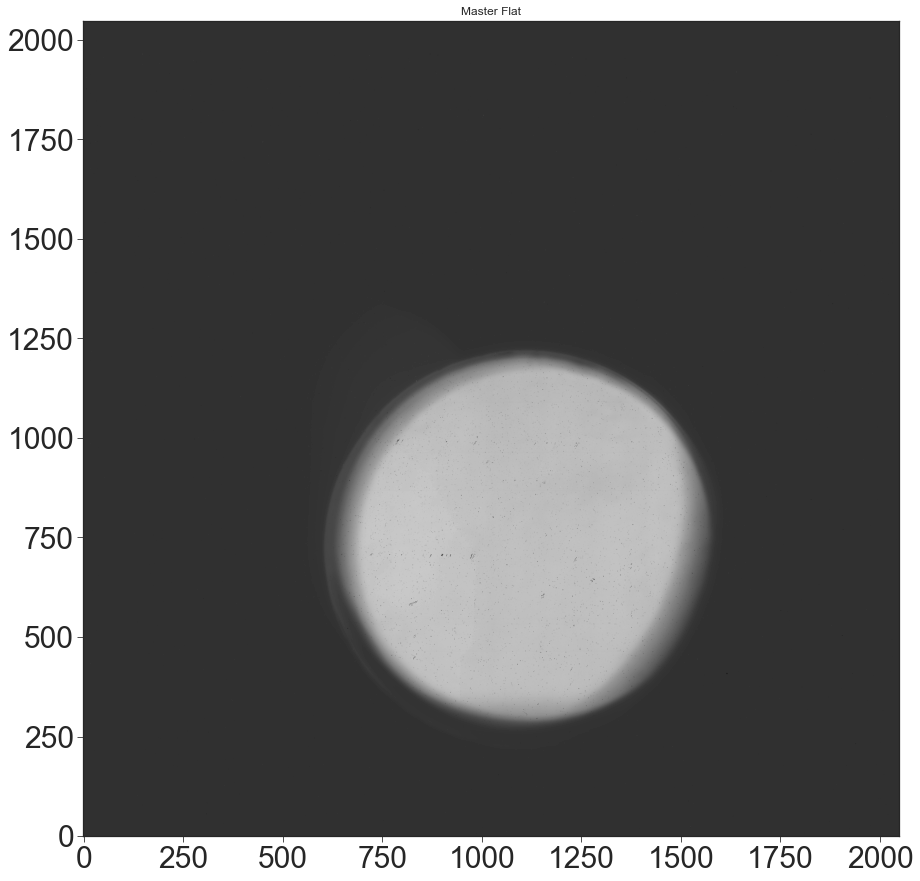

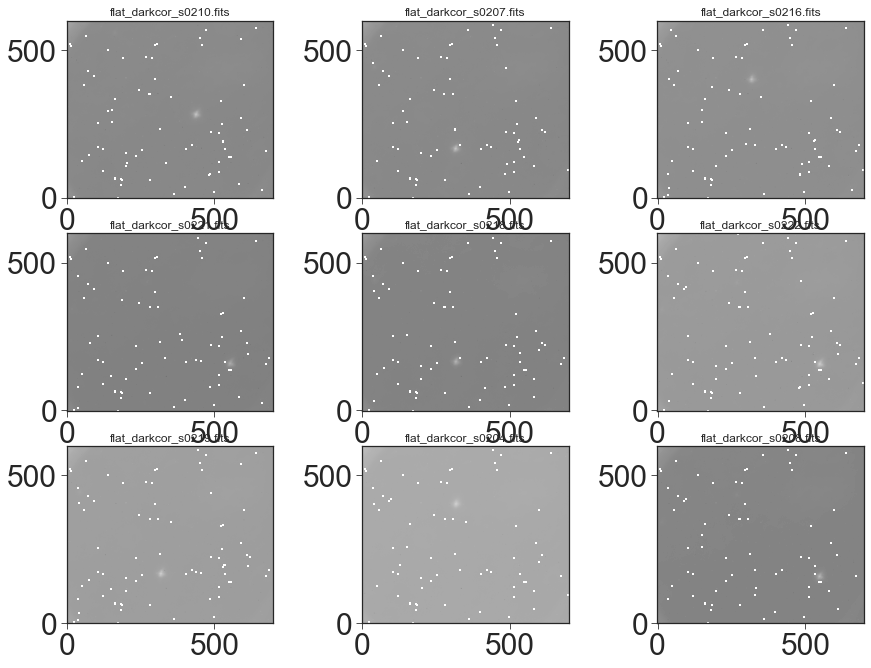

In [13]:
#############################################################################################
##############                 Flat Field Corrections      ##################################
#############################################################################################



    
darkcor_flat_filt_list = []
darkcor_flat_im_data = {} #make a dictionary our dark corrected flat data, NOT flat and dark corrected images
        

       
                    

## create an empty dictionary to populate with the completely corrected science frames: 
flat_darkcor_data_out = {} 
       
obj_filt_list = []
flat_filt_list = []


        
                
flat_darkcor_object_list_in_filt = ['darkcor_' + im for im in newobjectlist]
    
flat_darkcor_object_list_out_filt = ['flat_' + im for im in flat_darkcor_object_list_in_filt]
    
                

for flat in flat_list:
    try: 
        flatheader = fits.getheader(datadir+flat)
        flatfilt = flatheader['FILT1NAM']
                    
        if filter == flatfilt:
                        
            flat_filt_list.append(flat) #this makes a list of all flats with this particular filter
        else:
            continue
    except OSError:
        continue
                
flat_filt_list = ['darkcor_' + im for im in flat_filt_list]
        
for flat in flat_filt_list:
    darkcor_flat_im_data[flat] = darkcor_data_out[flat]
                

    

#making our master flat for this particular filter
flatcube = np.stack([darkcor_flat_im_data[flat_frame] for flat_frame in flat_filt_list],axis=0)

master_flat = np.average(flatcube, axis=0)


normalized_master_flat = master_flat/np.mean(master_flat)
    
   
    



plt.figure(figsize=(15,15))
plt.imshow((normalized_master_flat), origin='lower', cmap='gray')
plt.title('Master Flat')


## we're iterating over an integer here again because the lists match up
#here comes the actual flat correction
for i in range(len(flat_darkcor_object_list_in_filt)):

    flat_darkcor_data_out[flat_darkcor_object_list_out_filt[i]] = darkcor_data_out[flat_darkcor_object_list_in_filt[i]]/normalized_master_flat



targetcube_window = np.stack([flat_darkcor_data_out[science_frame][450:1050,750:1450] for science_frame in flat_darkcor_object_list_out_filt],axis=0)


    


## show the images: 
plot_grid(targetcube_window,flat_darkcor_object_list_out_filt)
            
    
    

In [12]:
#######################################################################################
##############         Sigma Cut                     ##################################
#######################################################################################

## Let's try the sigma cut

#I want to in principle go through every pixel of an image, check its value, if it's too high, veto it,
#otherwise, I will continue. This most likely will be done with boxes much bigger 
#maybe making a mask is better, if the bad pixel values don't change much


#Open a single data file and try this

flat_darkcor_sigmacut_data = {}
skyframe_data = {}


for img in flat_darkcor_object_list_out_filt:
    
    data = flat_darkcor_data_out[img][450:1050,850:1450]
    print(img)



    #create a new array
    data2 = np.zeros((600,600))

    

    for i in range(len(data)):
         for j in range(len(data[0])):

            neighbors = get_neighbors(i,j,data)
            nvals = np.median(neighbors)
            if np.abs(nvals-data[i][j]) < 10:
                data2[i][j] = data[i][j]
            else:
                data2[i][j] = nvals

    
    flat_darkcor_sigmacut_data[img] = data2
    
#     xcent,ycent,sigma,A = guess_gaussian_parameters(data2)
    

#     mval = np.median(data2)

#     for i in range(len(data2)):
#         for j in range(len(data2[0])):
#             dist = np.sqrt((i-ycent)**2+(j-xcent)**2)
#             if dist < 1*sigma:
#                 data2[i][j] = mval
#             else:
#                 continue
#     skyframe_data[img] = data2
        

#Wow, this really cleans up the images nicely. Let's use this to make master 
#sky frames, and try it implemented up above!
#I guess the idea is to fill the centroid area with the median value of the image



flat_darkcor_s0210.fits
flat_darkcor_s0207.fits
flat_darkcor_s0216.fits
flat_darkcor_s0221.fits
flat_darkcor_s0218.fits
flat_darkcor_s0222.fits
flat_darkcor_s0219.fits
flat_darkcor_s0204.fits
flat_darkcor_s0208.fits


70.0
Positions = 4


/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:281: RuntimeWarning: invalid value encountered in log10
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in log10
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in log10
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:301: RuntimeWarning: divide by zero encountered in log10
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:301: RuntimeWarning: invalid value encountered in log10
/Users/corey/Documents/Shane-AO-Reduction/utils.py:42: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(B), origin='lower', cmap='gray')


<Figure size 864x576 with 0 Axes>

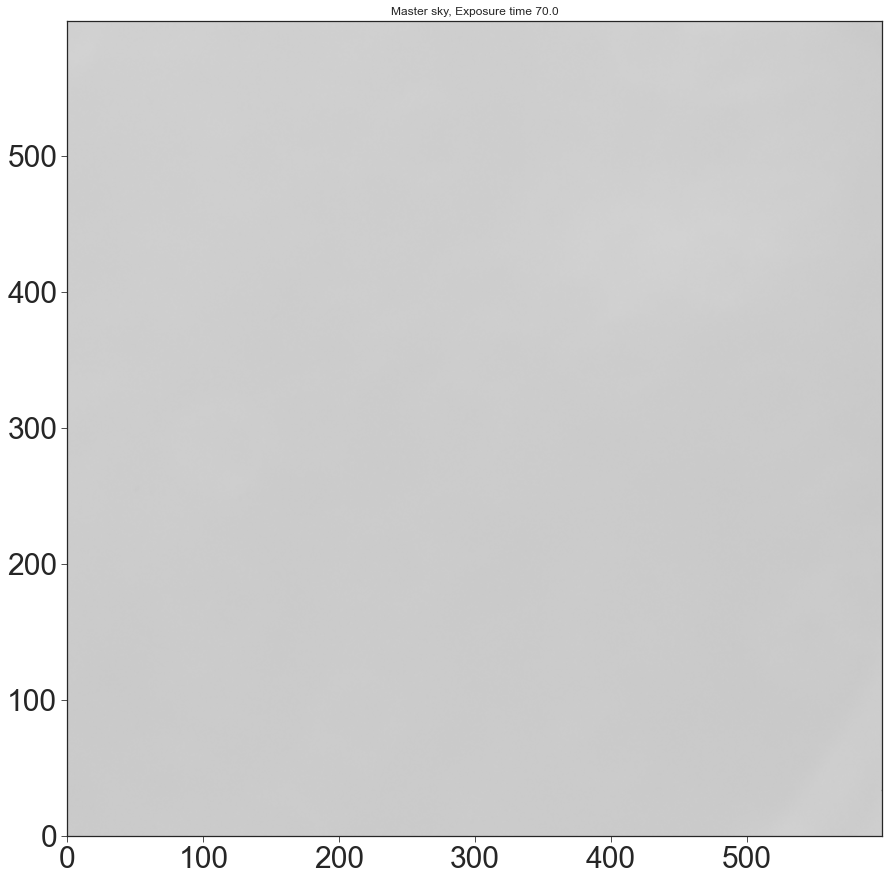

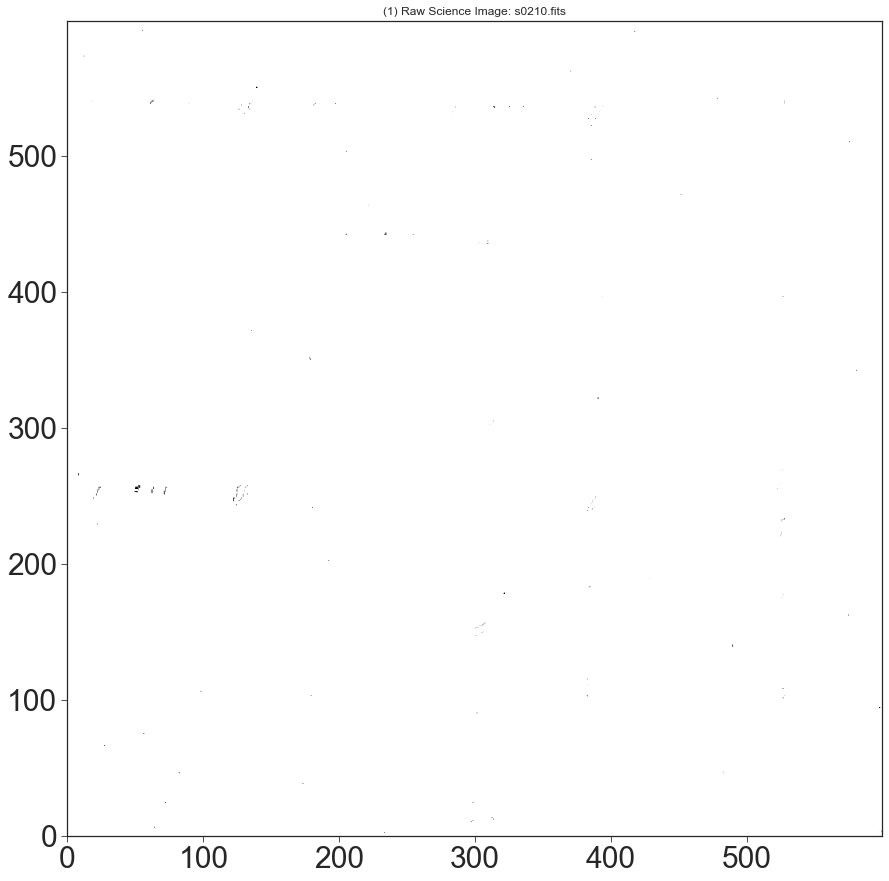

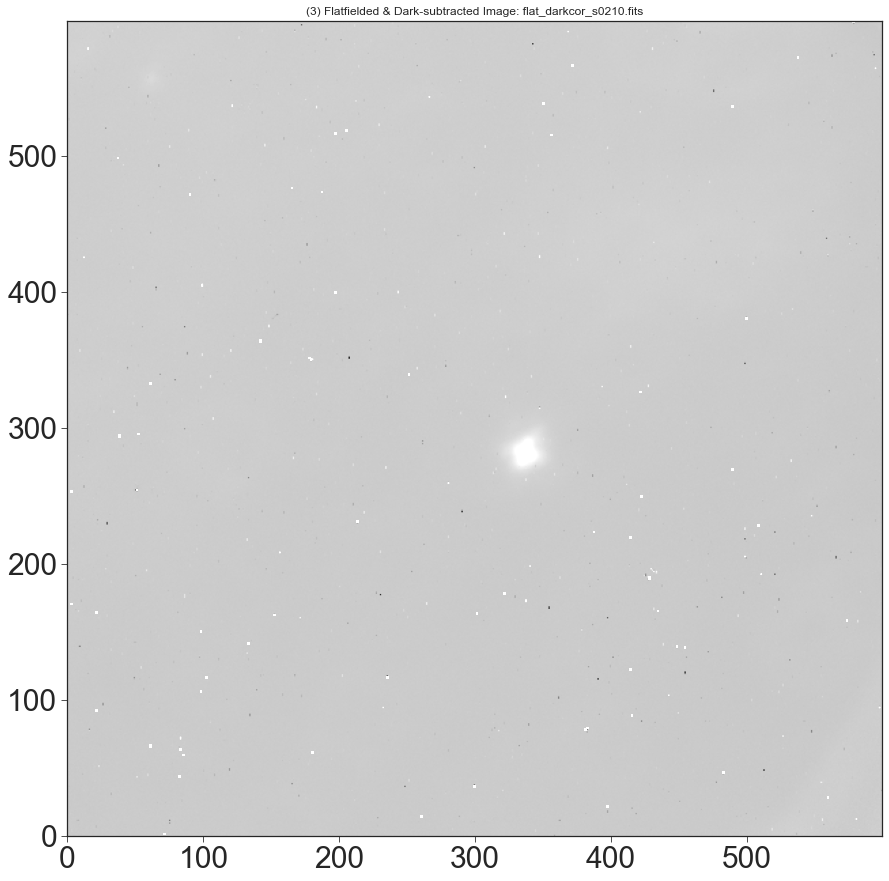

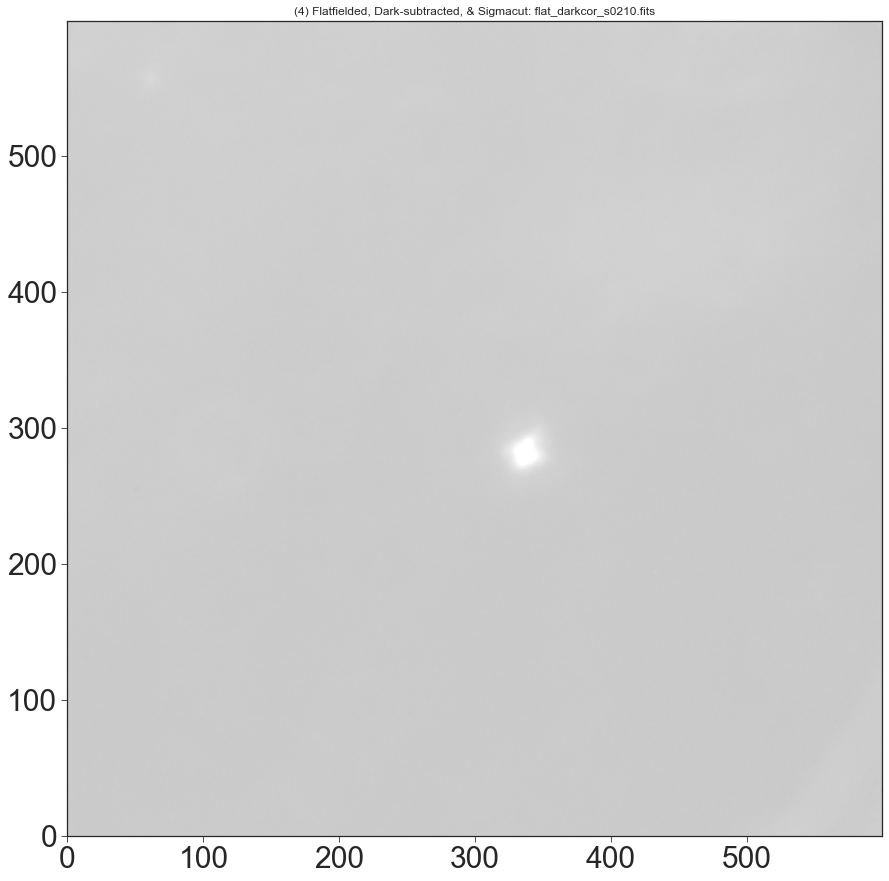

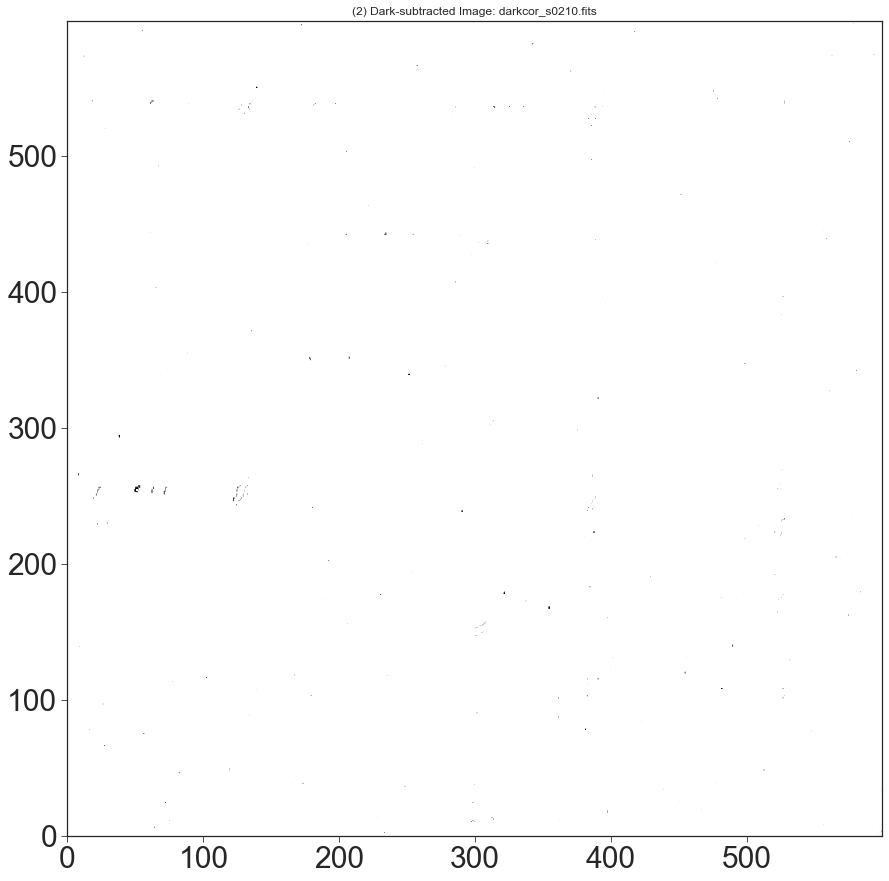

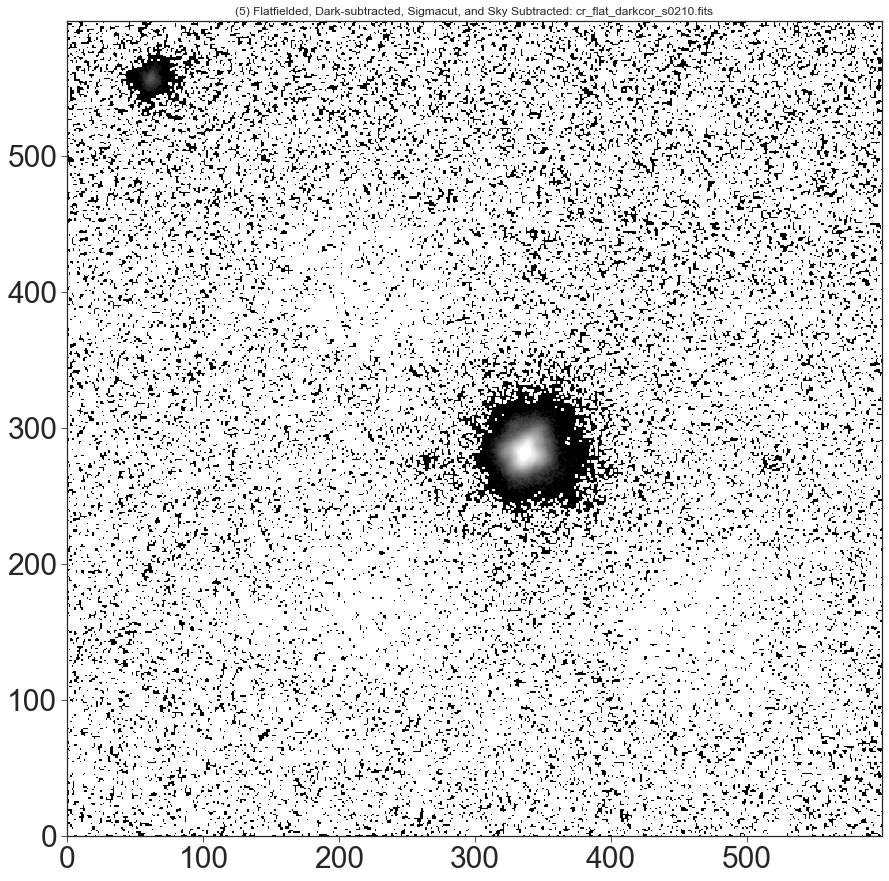

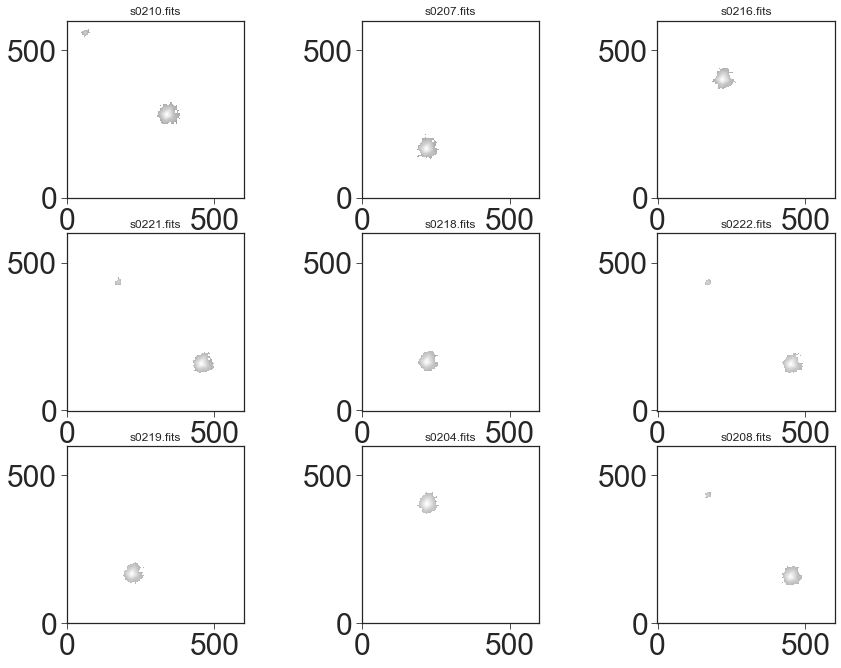

In [16]:
#######################################################################################
##############              Sky Correction            #################################
#######################################################################################



#Make a master sky frame for this target
#In case there is not much variance in the dither position, we need to make track them, and only 
#median images with different dither positions
        
## make a list to name the images: 
cr_flat_darkcor_target_list = ['cr_' + im for im in flat_darkcor_object_list_out_filt]

## create an empty dictionary to populate with the completely corrected science frames: 
cr_flat_darkcor_data_out = {}

#let's add some bits to account for different exposure times on images
exposuretimes = []
for obj in newobjectlist:
    header = fits.getheader(datadir+obj)
    if len(exposuretimes) == 0:
        exposuretimes.append(float(header['ITIME'])/1000)
    elif float(header['ITIME'])/1000 not in exposuretimes:
        exposuretimes.append(float(header['ITIME'])/1000)
    else:
        continue
explist = []      
#make a list of each data image in each exposure time
skycube = []
for time in exposuretimes:
    newlist = []
    for i in range(len(newobjectlist)):
        header = fits.getheader(datadir+newobjectlist[i])
        if time == float(header['ITIME'])/1000:
            newlist.append(newobjectlist[i])
        else:
            continue
    explist.append(newlist)
    
        

for i in range(len(exposuretimes)):
    print(exposuretimes[i])
    btmrt = []
    btmlft = []
    toprt = []
    toplft = []
    center = []

    for j in range(len(explist[i])): #for now just checking via centroid position
        x0,y0,sigma,A = guess_gaussian_parameters(flat_darkcor_sigmacut_data['flat_darkcor_'\
                                                                    +explist[i][j]])

        if x0 > 350 and y0 < 250:
            btmrt.append(explist[i][j])
        elif x0 > 350 and y0 > 350:
            toprt.append(explist[i][j])
        elif x0 < 250 and y0 < 250:
            btmlft.append(explist[i][j])
        elif x0 < 250 and y0 > 350:
            toplft.append(explist[i][j])
        else:
            center.append(explist[i][j])

    positions = [len(btmrt),len(btmlft),len(toprt),len(toplft),len(center)]
    nonzero = []
    pos = 5
    for num in positions:
        if num != 0:
            nonzero.append(num)
        else:
            pos = pos - 1
            continue
        
    min_dither = np.min(nonzero) #wanna know the smallest number of nonzero positions
                
                
    print('Positions = '+str(pos))
    if pos < 3:
        print('Exposure Time: '+str(exposuretimes[i]))
        print('Gonna delete: ')
        print(explist[i])
        for obj in explist[i]:
            object_list.remove(obj)
            darkcor_list_out.remove('darkcor_'+obj)
            flat_darkcor_object_list_out_filt.remove('flat_darkcor_'+obj)
            cr_flat_darkcor_target_list.remove('cr_flat_darkcor_'+obj)
            #newobjectlist.remove(obj)
            continue

                    
                    
#     if min_dither < 3:
#         print('Exposure Time: '+str(exposuretimes[i]))
#         print('Min Dither: '+ str(min_dither))
#         print('Gonna delete: ')
#         print(explist[i])
#         for obj in explist[i]:
#             object_list.remove(obj)
#             darkcor_list_out.remove('darkcor_'+obj)
#             flat_darkcor_object_list_out_filt.remove('flat_darkcor_'+obj)
#             cr_flat_darkcor_target_list.remove('cr_flat_darkcor_'+obj)
#             newobjectlist.remove(obj)
#         continue
        
    master_sky_list =[]
                
                
    skycubelist = [] #this is going to be a list of all the images we median for the sky frame
    
    for j in range(min_dither):
        if len(toprt) == 0:
            continue
        else:
            skycubelist.append(toprt[j])
        
    for j in range(min_dither):
        if len(toplft) == 0:
            continue
        else:
            skycubelist.append(toplft[j])
        
    for j in range(min_dither):
        if len(btmrt) == 0:
            continue
        else:
            skycubelist.append(btmrt[j])
        
    for j in range(min_dither):
        if len(btmlft) == 0:
            continue
        else:
            skycubelist.append(btmlft[j])
        
    for j in range(min_dither):
        if len(center) == 0:
            continue
        else:
            skycubelist.append(center[j])
        
                
                    
            
    
#     skycube = np.stack([flat_darkcor_data_out['flat_darkcor_'+science_frame][400:1000,850:1450] for\
#                     science_frame in skycubelist],axis=0)

#     master_sky = np.median(skycube,axis=0)

    
    skycube = np.stack([flat_darkcor_sigmacut_data['flat_darkcor_'+science_frame] for science_frame\
                        in skycubelist],axis=0)

    master_sky = np.median(skycube,axis=0)
            
 
     ###Addding our new sky frame stuff here

#     xcent=300
#     ycent=300
#     toplft_sky_list = []
#     toplft_sky = {}

#     for j in range(len(explist[i])):
#         if explist[i][j] not in toplft and explist[i][j] not in center:
#             toplft_sky_list.append(explist[i][j])

    
#     toplft_skycube = np.stack([flat_darkcor_sigmacut_data['flat_darkcor_'+science_frame][ycent:ycent+300,xcent-300:xcent] for\
#                     science_frame in toplft_sky_list],axis=0)
#     toplft_sky = np.median(toplft_skycube,axis=0)


#     btmlft_sky_list = []
#     btmlft_sky = {}

#     for j in range(len(explist[i])):
#         if explist[i][j] not in btmlft and explist[i][j] not in center:
#             btmlft_sky_list.append(explist[i][j])

    
#     btmlft_skycube = np.stack([flat_darkcor_sigmacut_data['flat_darkcor_'+science_frame][ycent-300:ycent,xcent-300:xcent] for\
#                     science_frame in btmlft_sky_list],axis=0)
#     btmlft_sky = np.median(btmlft_skycube,axis=0)



#     toprt_sky_list = []
#     toprt_sky = {}

#     for j in range(len(explist[i])):
#         if explist[i][j] not in toprt and explist[i][j] not in center:
#             toprt_sky_list.append(explist[i][j])

    
#     toprt_skycube = np.stack([flat_darkcor_sigmacut_data['flat_darkcor_'+science_frame][ycent:ycent+300,xcent:xcent+300] for\
#                                     science_frame in toprt_sky_list],axis=0)
#     toprt_sky = np.median(toprt_skycube,axis=0)


#     btmrt_sky_list = []
#     btmrt_sky = {}

#     for j in range(len(explist[i])):
#         if explist[i][j] not in btmrt and explist[i][j] not in center:
#             btmrt_sky_list.append(explist[i][j])

    
#     btmrt_skycube = np.stack([flat_darkcor_sigmacut_data['flat_darkcor_'+science_frame][ycent-300:ycent,xcent:xcent+300] for\
#                                     science_frame in btmrt_sky_list],axis=0)
#     btmrt_sky = np.median(btmrt_skycube,axis=0)

# #now we create an array that has each of these four sky frames stiched together

#     final_sky = np.zeros((600,600))

#     for k in range(0,300):
#         for l in range(0,300):
#             final_sky[k+300][l] = toplft_sky[k][l]
#             final_sky[k+300][l+300] = toprt_sky[k][l]
#             final_sky[k][l] = btmlft_sky[k][l]
#             final_sky[k][l+300] = btmrt_sky[k][l]


    graymin = 1.25
    graymax = 3


#Show the master sky. Will need to edit this for each target eventually, probably
    plt.figure(1)
    plt.figure(figsize=(15,15));
    plt.title('Master sky, Exposure time '+str(exposuretimes[i]));
    plt.imshow(np.log10(master_sky), origin='lower', cmap='gray',vmin=graymin,vmax=graymax)




#Sky subtraction and Cosmic ray removal
#Don't need cr removal after sigma cut

        

    for j in range(len(explist[i])):
        skysub_image = flat_darkcor_sigmacut_data['flat_darkcor_'+explist[i][j]] - master_sky
        cr_flat_darkcor_data_out['cr_flat_darkcor_'+explist[i][j]] = skysub_image
        
if len(newobjectlist) == 0:
    print('Target: '+str(target)+' not good enough')
    sys.exit()
    
# so if we compare the initial raw science frame (1), to a dark-corrected (2), a flatfield & dark-corrected frame (3), and CR-removed (4) 
# we can see the progression in lessening noise

## grayscale mapping min/max values: 


im = 0  ## the image we're looking at.

## (1) raw image
im1 = newobjectlist[im]
data_im1 = raw_image_data[im1]

## (2) dark-corrected image
im1_d = darkcor_list_out[im]
data_im1_d = darkcor_data_out[im1_d]

## (3) flattened and dark-corrected image
im1_d_f = flat_darkcor_object_list_out_filt[im]
data_im1_d_f = flat_darkcor_data_out[im1_d_f]

## (4) flattened, dark-corrected, Sigma_Cut, and Sky Subtracted Image
im1_d_f_s = flat_darkcor_object_list_out_filt[im]
data_im1_d_f_s = flat_darkcor_sigmacut_data[im1_d_f_s]

## (5) flattened, dark-corrected, Sigma_Cut, and Sky Subtracted Image
im1_d_f_s_s = cr_flat_darkcor_target_list[im]
data_im1_d_f_s_s = cr_flat_darkcor_data_out[im1_d_f_s_s]

plt.figure(1)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1[450:1050,850:1450]), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(1) Raw Science Image: ' + im1)

plt.figure(2)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d[450:1050,850:1450]), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(2) Dark-subtracted Image: ' + im1_d)

plt.figure(3)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d_f[450:1050,850:1450]), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(3) Flatfielded & Dark-subtracted Image: ' + im1_d_f)

plt.figure(4)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d_f_s), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(4) Flatfielded, Dark-subtracted, & Sigmacut: ' + im1_d_f_s)

plt.figure(4)
plt.figure(figsize=(15,15))
plt.imshow(np.log10(data_im1_d_f_s_s), origin='lower', cmap='gray', vmin=graymin, vmax=graymax)
plt.title('(5) Flatfielded, Dark-subtracted, Sigmacut, and Sky Subtracted: ' + im1_d_f_s_s)

    
#let's see if some cleanup here helps
         
#del flat_darkcor_data_out


## create an array of corrected target images
targetcube = np.stack([cr_flat_darkcor_data_out[science_frame] for science_frame in cr_flat_darkcor_target_list],axis=0)

## show the images: 
plot_grid(targetcube,object_list)
            
            
    



/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10
/Users/corey/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in log10


<Figure size 864x576 with 0 Axes>

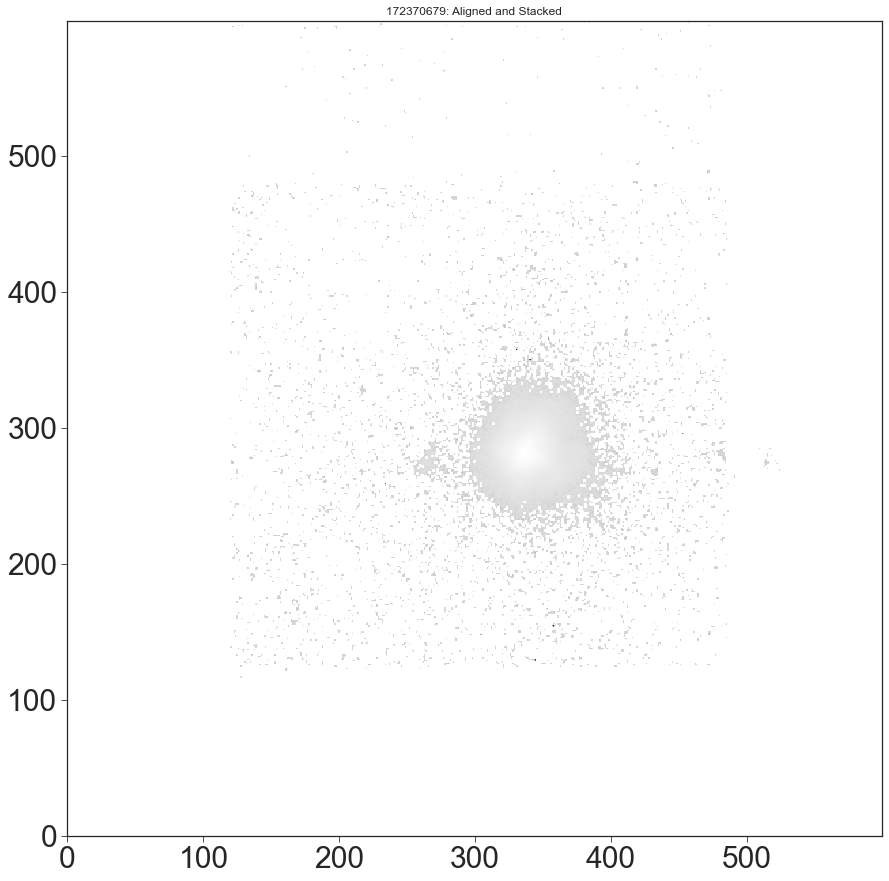

In [22]:
#################################################################################
################           Image Shifting      ##################################
#################################################################################





#Want to write something that checks all of these and finds the one with the highest S/N ratio
#I'm thinking we can take the ratio of the centroid counts to some random background area
#Will have to use that guess Gaussian parameters to find the centroid
highest = 0
zero_shift_image = 'cr_flat_darkcor_'+center[0]
for i in range(len(center)):
    data = cr_flat_darkcor_data_out['cr_flat_darkcor_'+center[i]]

    x0,y0,sigma,A = guess_gaussian_parameters(data)
    centroid_window = data[y0-1:y0+1,x0-1:x0+1]
    cent_counts = np.mean(centroid_window)
    x1 = x0-200
    y1 = y0-200
    noise_window = data[y1-5:y1+5,x1-5:x1+5]
    noise = abs(np.mean(noise_window))
    StN = cent_counts/noise
    if StN > highest:
        highest = StN
        zero_shift_image = 'cr_flat_darkcor_'+center[i]
        numb = i
        header = fits.getheader(datadir+center[i])
        
## find all shifts for other images: 
imshifts = {} # dictionary to hold the x and y shift pairs for each image
for image in cr_flat_darkcor_target_list: 
## register_translation is a function that calculates shifts by comparing 2-D arrays
    result, error, diffphase = phase_cross_correlation(
        cr_flat_darkcor_data_out[zero_shift_image], 
        cr_flat_darkcor_data_out[image])
    imshifts[image] = result
    
    
    
## new list for shifted image names: 
shifted_target_list = ['shifted_' + im for im in cr_flat_darkcor_target_list]

## new dictionary for shifted image data: 
shifted_target_data = {}
for i in range(len(shifted_target_list)):
    ## interp.shift is the function doing the heavy lifting here,
    ## it's reinterpolating each array into the new, shifted one
    shifted_target_data[shifted_target_list[i]] = interp.shift(
        cr_flat_darkcor_data_out[cr_flat_darkcor_target_list[i]], 
        imshifts[cr_flat_darkcor_target_list[i]])

    
## array of aligned arrays: 
targetcube_shift  = np.stack(shifted_target_data.values(),axis=0)

## average combined final image: 
target_stacked = np.median(targetcube_shift, axis=0)


## show the final image array as an image: 
plt.figure(1)
plt.figure(figsize=(15,15));
plt.title(target+': Aligned and Stacked');
plt.imshow(np.log10(target_stacked), origin='lower', cmap='gray')
plt.savefig(outdir+target+'.png',dpi=300)

In [23]:
## Clean up and file saving

#del cr_flat_darkcor_data_out
            
print(len(object_filter_list))
#change the size of the image in the header file
header['NAXIS1'] = 600
header['NAXIS2'] = 600
header['CRPIX1'] = 300
header['CRPIX2'] = 350
            
if len(object_filter_list) > 1: 

    fits.writeto(outdir + target+'_final'+str(filter)+'.fits', target_stacked, header)
else:
    fits.writeto(outdir + target+'_final.fits', target_stacked, header)
            
            
#del raw_image_data
#del darkcor_data_out
    

1


In [38]:
np.std(target_stacked)

30.312913485079747